In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files u

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dog-emotions-prediction/images/angry/7757094582_57943f86ea_b.jpg
/kaggle/input/dog-emotions-prediction/images/angry/6585062535_999ebe75b1_b.jpg
/kaggle/input/dog-emotions-prediction/images/angry/5591997280_374449d3a2_b.jpg
/kaggle/input/dog-emotions-prediction/images/angry/15006271570_ae5483cc0d_b.jpg
/kaggle/input/dog-emotions-prediction/images/angry/6804157447_48f3668c77_b.jpg
/kaggle/input/dog-emotions-prediction/images/angry/4569091661_bf0dc26de6_b.jpg
/kaggle/input/dog-emotions-prediction/images/angry/5416734020_6268e938a9_b.jpg
/kaggle/input/dog-emotions-prediction/images/angry/1661491166_e47d275242_b.jpg
/kaggle/input/dog-emotions-prediction/images/angry/9970288695_12bda09445_b.jpg
/kaggle/input/dog-emotions-prediction/images/angry/3567997681_99b0cffe65_b.jpg
/kaggle/input/dog-emotions-prediction/images/angry/5132048873_5f9c05218e_b.jpg
/kaggle/input/dog-emotions-prediction/images/angry/5901286410_11444f0cb7_b.jpg
/kaggle/input/dog-emotions-prediction/images/angry/

In [2]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [3]:
INPUT_PATH = "../input/dog-emotions-prediction/images/"
EMOTIONS = ["angry", "sad", "happy"]

total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in EMOTIONS:
        count = 0
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            count += 1
            total_images += 1
        print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

angry has 2256 number of images
sad has 4532 number of images
happy has 4784 number of images

total images are 11572


In [4]:
img_arr = np.empty(shape=(total_images, 96, 96, 3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_resized = cv2.resize(img, (96, 96))
            img_arr[i] = img_resized
            img_label[i] = e
            i += 1
        e += 1

img_arr.shape, img_label.shape

((11572, 96, 96, 3), (11572,))

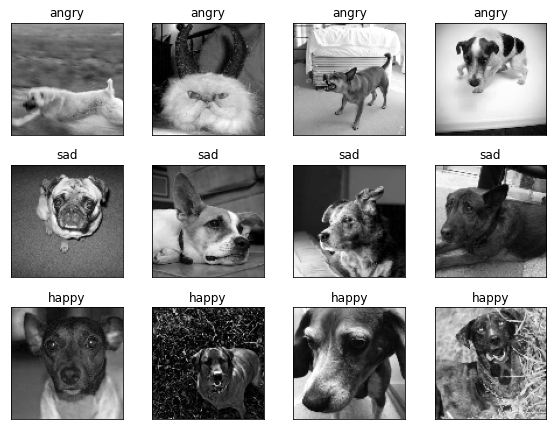

In [5]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [6]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(11572, 3)

In [7]:
img_arr = img_arr / 255.

X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label, shuffle = True, stratify = img_label, train_size = 0.9, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10414, 96, 96, 3), (1158, 96, 96, 3), (10414, 3), (1158, 3))

In [8]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [9]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name = "global_pool")(x)
out = Dense(num_classes, activation = "softmax", name = "out_layer")(global_pool)

model = Model(inputs = mobile_net.input, outputs = out)

for layer in model.layers[:15]:
    layer.trainable = False

17235968/17225924 [==============================] - 1s 0us/step


In [10]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True,
    zca_whitening = False,
)
train_datagen.fit(X_train)

In [11]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.00008,
    patience = 11,
    verbose = 1,
    restore_best_weights = True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    min_delta = 0.0001,
    factor = 0.25,
    patience = 4,
    min_lr = 1e-7,
    verbose = 1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [12]:
batch_size = 25
epochs = 100

optim = optimizers.Nadam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)

model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optim,
        metrics = ['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size = batch_size),
    validation_data = (X_test, y_test),
    steps_per_epoch = len(X_train) / batch_size,
    epochs = epochs,
    callbacks = callbacks,
    use_multiprocessing=True
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
416/416 [==============================] - 139s 316ms/step - loss: 1.1506 - accuracy: 0.5263 - val_loss: 0.9519 - val_accuracy: 0.5674
Epoch 2/100
416/416 [==============================] - 132s 315ms/step - loss: 0.9241 - accuracy: 0.5955 - val_loss: 0.8958 - val_accuracy: 0.6088
Epoch 3/100
416/416 [==============================] - 131s 314ms/step - loss: 0.8552 - accuracy: 0.6301 - val_loss: 0.8501 - val_accuracy: 0.6408
Epoch 4/100
416/416 [==============================] - 130s 310ms/step - loss: 0.8370 - accuracy: 0.6344 - val_loss: 0.8709 - val_accuracy: 0.6347
Epoch 5/100
416/416 [==============================] - 131s 313ms/step - loss: 0.8080 - accuracy: 0.6529 - val_loss: 0.8436 - val_accuracy: 0.6528
Epoch 6/100
416/416 [==============================] - 130s 312ms/step - loss: 0.7953 - accuracy: 0.6580 - val_loss: 0.8549 - val_accuracy: 0.6598
Epoch 7/100
416/416 [==============================] - 132s 315ms/step - loss: 0.7783 - accuracy: 0.6672 - val_loss: 0

In [14]:
model.save("dog_emotion_model.h5")